In [ ]:
# basic imports
import os
import re
import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline 
import seaborn as sns
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

## I. Exploratory data analysis

### I.A. Data preparation and analysis

In [12]:
#Expected rate for each word in the vocabulary

def load_embeddings():
    # Load rates
    logger.info("Loading embedding vectors...")
    rates= np.genfromtxt('aclImdb/imdbEr.txt')
    logger.info(f"Loaded vectors with shape: {rates.shape}")
    
    # Load associated words
    logger.info("Loading words...")
    with open('aclImdb/imdb.vocab', 'r', encoding='utf-8') as f:
        words = [line.strip() for line in f.readlines()]
    logger.info(f"Loaded {len(words)} words")
    
    if len(words) != rates.shape[0]:
        raise ValueError(f"Mismatch between number of words ({len(words)}) and vectors ({rates.shape[0]})")
    
    logger.info("Verification complete - sizes match!")
    
    return rates, words

rates, words = load_embeddings()

print("\nDataset information:")
print(f"Number of words (vocab): {len(words)}")
print(f"Number of vectors (rates): {rates.shape[0]}")
print(f"\nFirst few words and their expected rates {[(word, rate) for (word, rate) in zip(words[:5], rates[:5])]}")


09:34:58 INFO:Loading embedding vectors...
09:34:58 INFO:Loaded vectors with shape: (89527,)
09:34:58 INFO:Loading words...
09:34:58 INFO:Loaded 89527 words
09:34:58 INFO:Verification complete - sizes match!



Dataset information:
Number of words (vocab): 89527
Number of vectors (rates): 89527

First few words and their expected rates [('the', 0.0490972013402), ('and', 0.201363575849), ('a', 0.0333946807184), ('of', 0.099837669572), ('to', -0.0790210365788)]


In [22]:
#words with rate < 0.25 will be considered as stop words
stopwords = [word for word, rate in zip(words, rates) if np.abs(rate) < 0.7]
print(f"Nombre de stop words détectés : {len(stopwords)}")

#save stop words
with open("aclImdb/stop_word_rate.txt", "w", encoding="utf-8") as f:
    for word in stopwords:
        f.write(word + "\n")

print("Le fichier stop_word_rate.txt a été créé avec succès.")

Nombre de stop words détectés : 63286
Le fichier stop_word_rate.txt a été créé avec succès.


In [33]:
def clean_review(text):
    """
    Removes <br /> 
    """
    text = re.sub(r'<br\s*/?>', ' ', text)
    return text

def process_movie_reviews(directory_path: str) -> pd.DataFrame:
    """
    Traite les fichiers de critiques de films et les combine dans un DataFrame.
    Args:
        directory_path (str): Chemin vers le répertoire contenant les fichiers texte
    Returns:
        pd.DataFrame: DataFrame contenant les colonnes id, rate, et comment
    """

    movie_ids = []
    rates = []
    comments = []
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            # id et note du nom du fichier

            parts = filename.split('_')
            if len(parts) == 2:
                movie_id = int(parts[0])
                rate = int(parts[1].split('.')[0])
                
                with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as f:
                    comment = f.read().strip()
                    comment = clean_review(comment) 
                
                # Ajouter les données aux listes
                movie_ids.append(movie_id)
                rates.append(rate)
                comments.append(comment)
    
    df = pd.DataFrame({
        'id': movie_ids,
        'rate': rates,
        'comment': comments
    })
    
    # Trier par id de film
    df = df.sort_values('id')
    
    return df

pos_df = process_movie_reviews('aclImdb/train/pos')
neg_df = process_movie_reviews('aclImdb/train/neg')

#labelling 
pos_df['sentiment'] = 1
neg_df['sentiment'] = 0

# Create dataset with positive and negative reviews
df = pd.concat([pos_df, neg_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### I.2. Data vizualisation

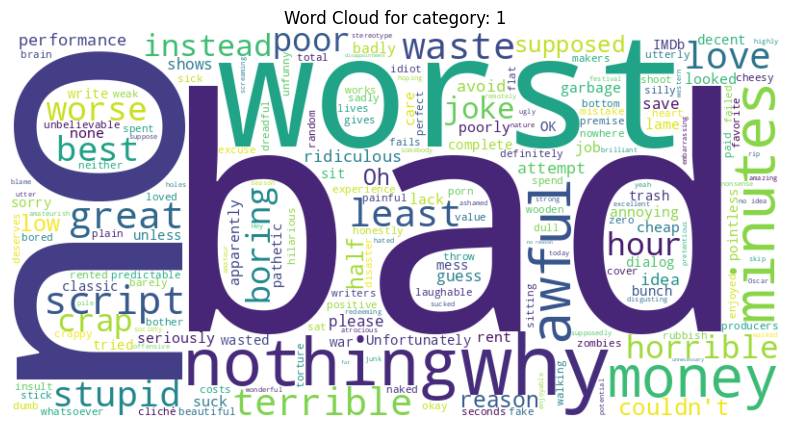

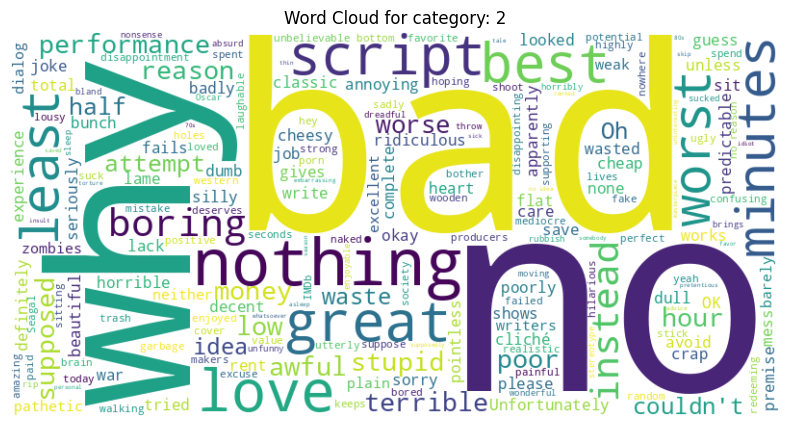

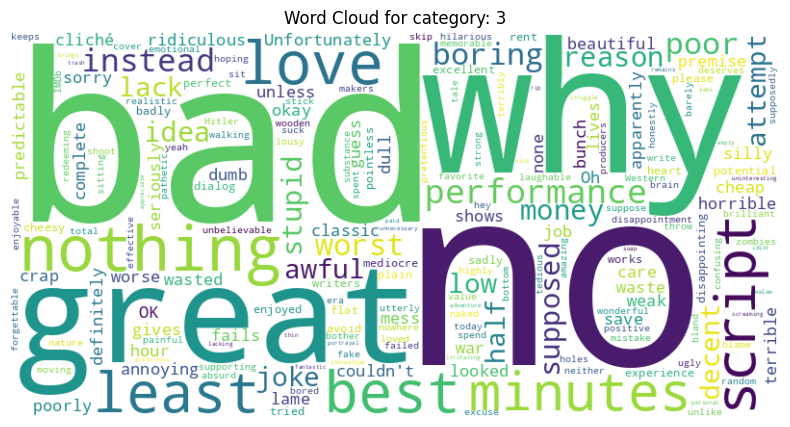

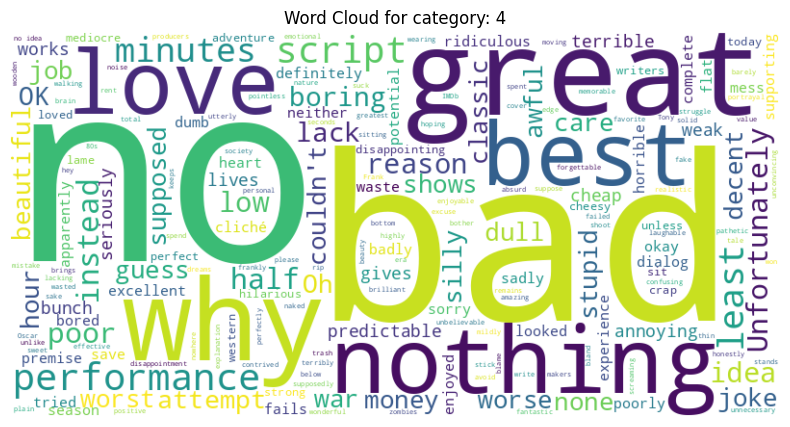

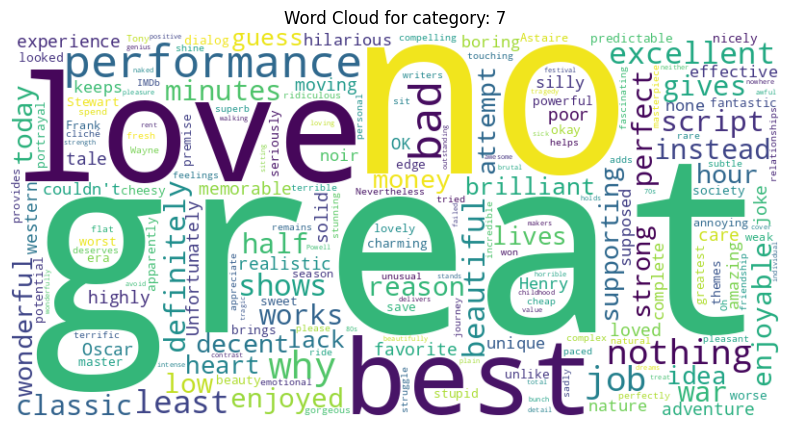

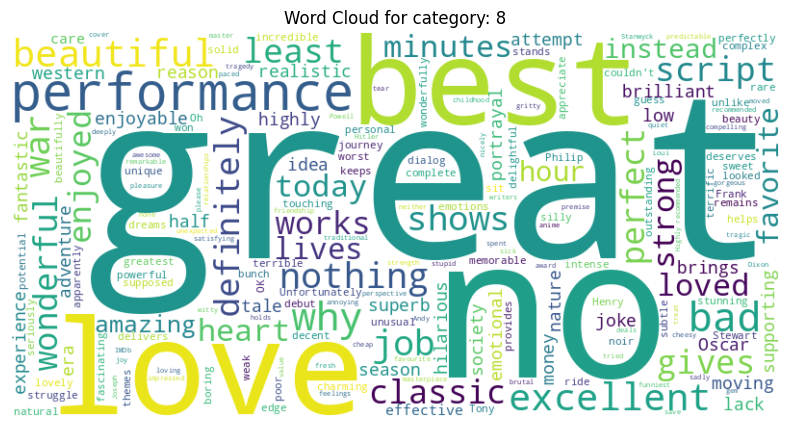

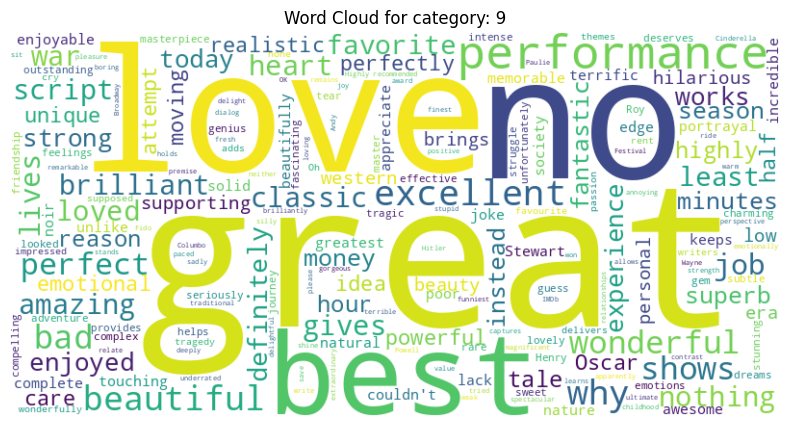

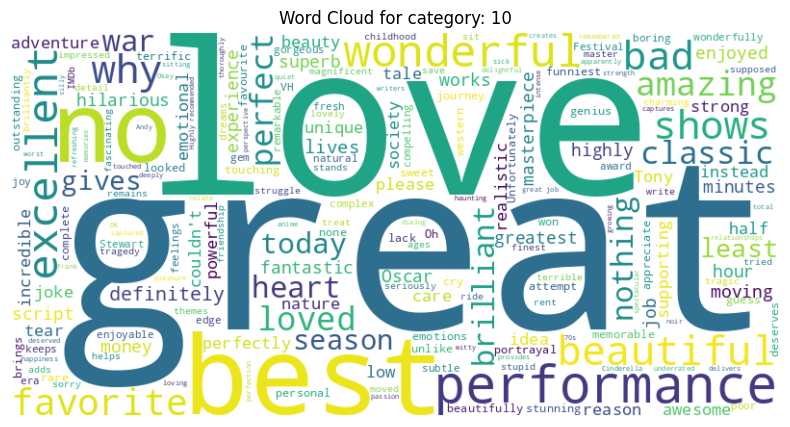

In [34]:
#worcloud by rate (from 1 to 10)

#we will consider the stopwords as the np.abs(rate)<0.05
STOPWORDS = [x.strip() for x in open('aclImdb/stop_word_rate.txt').readlines()]

# plot a word cloud for each category
for rate in sorted(df['rate'].unique()):
 # Filter the DataFrame for the current category
    df_cat = df[df['rate'] == rate]

    # Combine all articles in the category into one string
    text = " ".join(df_cat['comment'].tolist())

    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for category: {rate}")
    plt.show()

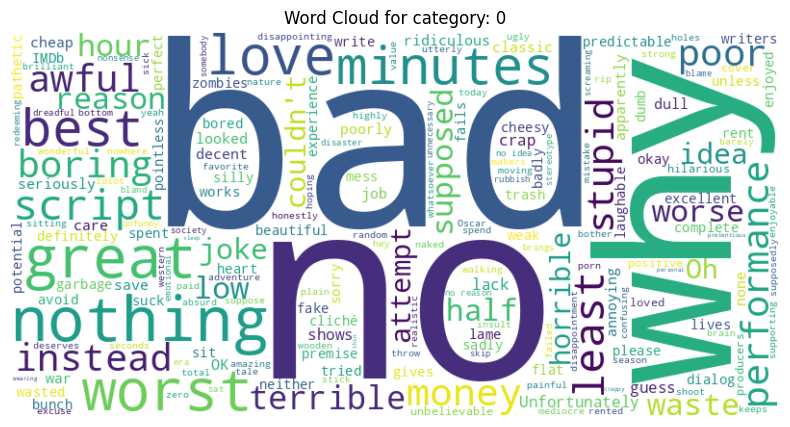

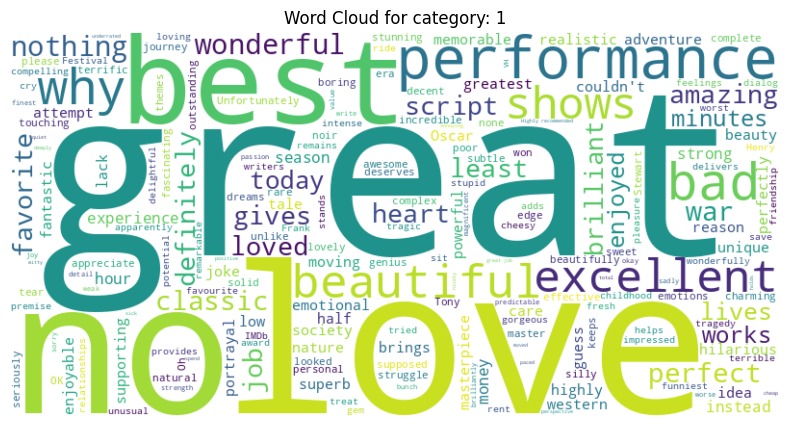

In [35]:
#wordcloud for sentiment (positive, negative)

#we will consider the stopwords as the np.abs(rate)<0.05
STOPWORDS = [x.strip() for x in open('aclImdb/stop_word_rate.txt').readlines()]

for sentiment in [0, 1]:
    df_cat = df[df['sentiment'] == sentiment]
    text = " ".join(df_cat['comment'].tolist())
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for category: {sentiment}")
    plt.show()

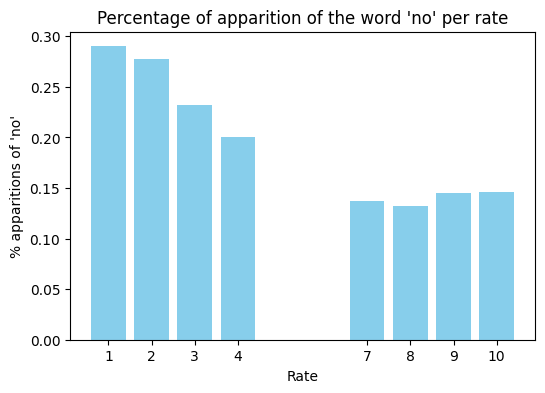

In [ ]:
#we see that the words no appears a lot in the positive as in the negative reviews. 
#Let's see if there is a difference in occurrences between positive and negative reviews

rates = sorted(df['rate'].unique())
percentages_no = []

for rate in rates:
    df_cat = df[df['rate'] == rate]
    text = " ".join(df_cat['comment'].tolist()).lower().split()

    total_words = len(text)
    no_count = text.count('no')
    percentage = (no_count / total_words) * 100
    percentages_no.append(percentage)

plt.figure(figsize=(6, 4))
plt.bar(rates, percentages_no, color='skyblue')
plt.xlabel('Rate')
plt.ylabel("% apparitions of 'no'")
plt.title("Percentage of apparition of the word 'no' per rate")
plt.xticks(rates)
plt.show()


## II. Classification

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

### II.A. Binary classification with Naive Bayes and TF-IDF

In [42]:
X = df['comment']
y = df['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [43]:
# We'll test different configurations
max_features_options = [1000, 2000, 5000]
use_idf_options = [True, False]  # Test with and without IDF
alpha_options = [0.1, 1.0, 10.0]  # Smoothing parameter for Naive Bayes

results = []

for max_features in max_features_options:
    for use_idf in use_idf_options:
        for alpha in alpha_options:
            # Create and fit the vectorizer on training data only
            vectorizer = CountVectorizer(max_features=max_features)
            X_train_counts = vectorizer.fit_transform(X_train)
            X_val_counts = vectorizer.transform(X_val)
            
            # Apply TF-IDF transformation
            tfidf = TfidfTransformer(use_idf=use_idf)
            X_train_tfidf = tfidf.fit_transform(X_train_counts)
            X_val_tfidf = tfidf.transform(X_val_counts)
            
            # Train classifier
            clf = MultinomialNB(alpha=alpha)
            clf.fit(X_train_tfidf, y_train)
            
            train_score = clf.score(X_train_tfidf, y_train)
            val_score = clf.score(X_val_tfidf, y_val)
            
            config = {
                'max_features': max_features,
                'use_idf': use_idf,
                'alpha': alpha,
                'train_accuracy': train_score,
                'val_accuracy': val_score
            }
            results.append(config)

best_config = max(results, key=lambda x: x['val_accuracy'])
print("\nBest configuration (based on validation accuracy):")
print("-" * 80)
print(f"Max Features: {best_config['max_features']}")
print(f"Use IDF: {best_config['use_idf']}")
print(f"Alpha: {best_config['alpha']}")
print(f"Train Accuracy: {best_config['train_accuracy']:.4f}")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")


Best configuration (based on validation accuracy):
--------------------------------------------------------------------------------
Max Features: 5000
Use IDF: True
Alpha: 0.1
Train Accuracy: 0.8681
Validation Accuracy: 0.8496
